In [20]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [21]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

In [22]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["School", "Player_Type", "Position_Type", "Position"]

for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([X[col], test[col]]).astype(str)
    le.fit(all_values)
    
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

###　05モデルからBMIを削除

In [24]:
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

X = X.drop(columns=["School"])
test = test.drop(columns=["School"])

In [25]:
columns_to_drop = ["Player_Type", "Position_Type"]
X = X.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

In [26]:
# エンコード前のPosition列を再読み込みして復元
df_raw = pd.read_csv("../data/train.csv")
X["Position"] = df_raw["Position"]

test_raw = pd.read_csv("../data/test.csv")
test["Position"] = test_raw["Position"]

In [27]:
# PositionをTarget Encoding（全体平均ベース、これは許容範囲）
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# Position_groupを作成（これは合法・安全）
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

# fold-safeな target encoding を実施
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0  # 初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)

# testデータには全体平均から算出（合法）
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

# 不要な文字列列は削除（エラー防止）
X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

C:\Users\81807\AppData\Local\Temp\ipykernel_18584\3887577351.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

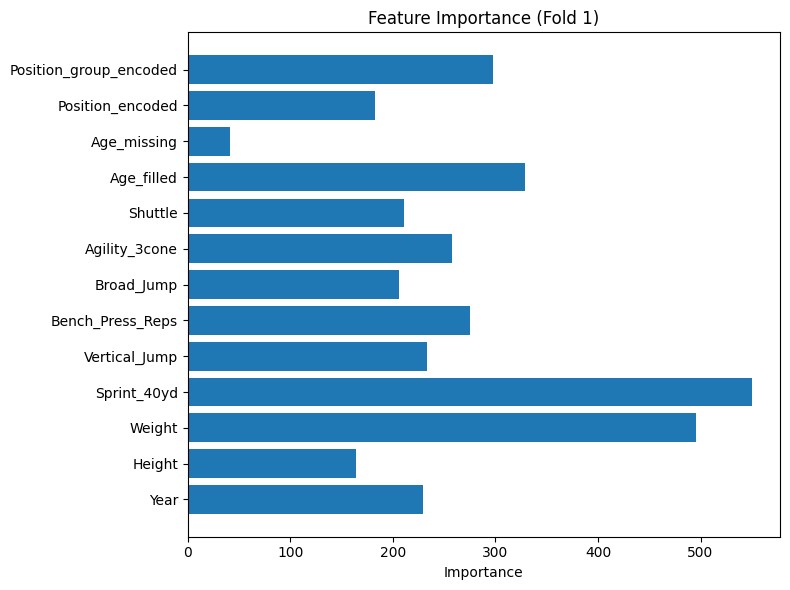

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=4,
    num_leaves=10,  # ←15→10
    min_child_samples=50,  # ←30→50
    reg_alpha=5.0,  # ←3.0→5.0
    reg_lambda=5.0,  # ←2.0→5.0
    learning_rate=0.03,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")

# LightGBM × Optuna による自動ハイパーパラメータチューニング

In [29]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [30]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 8, 64),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "n_estimators": 700,
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "random_state": 42
    }

    aucs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, valid_idx in kf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric="auc",
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=30),
                      lgb.log_evaluation(0)
                  ])
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        aucs.append(auc)

    return sum(aucs) / len(aucs)

In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-06-27 13:07:55,123] A new study created in memory with name: no-name-bf60b7cc-8ea5-4780-adb2-947511b17b05


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:07:55,361] Trial 0 finished with value: 0.8262796737240248 and parameters: {'max_depth': 6, 'num_leaves': 52, 'min_child_samples': 78, 'learning_rate': 0.03685028837515128, 'subsample': 0.9932522081810307, 'colsample_bytree': 0.5016218107715693, 'reg_alpha': 2.035472856107133, 'reg_lambda': 7.461166790007777}. Best is trial 0 with value: 0.8262796737240248.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:55,780] Trial 1 finished with value: 0.8227830169819189 and parameters: {'max_depth': 3, 'num_leaves': 43, 'min_child_samples': 62, 'learning_rate': 0.018930901478699892, 'subsample': 0.893905216122997, 'colsample_bytree': 0.7581242910579884, 'reg_alpha': 0.22709273637572358, 'reg_lambda': 0.38364579382492825}. Best is trial 0 with value: 0.8262796737240248.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:07:56,168] Trial 2 finished with value: 0.8199407111377827 and parameters: {'max_depth': 4, 'num_leaves': 34, 'min_child_samples': 92, 'learning_rate': 0.006114605331285568, 'subsample': 0.9820332423847279, 'colsample_bytree': 0.6970102657604857, 'reg_alpha': 2.950593852681042, 'reg_lambda': 5.839434440736115}. Best is trial 0 with value: 0.8262796737240248.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-06-27 13:07:56,587] Trial 3 finished with value: 0.8185992517079279 and parameters: {'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 16, 'learning_rate': 0.01348695104442142, 'subsample': 0.7929008488329634, 'colsample_bytree': 0.8432607936580866, 'reg_alpha': 4.103375613594935, 'reg_lambda': 6.538341756156662}. Best is trial 0 with value: 0.8262796737240248.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-06-27 13:07:56,876] Trial 4 finished with value: 0.7913769464387787 and parameters: {'max_depth': 3, 'num_leaves': 24, 'min_child_samples': 72, 'learning_rate': 0.0050868814209313945, 'subsample': 0.9544620649982112, 'colsample_bytree': 0.9259466926119043, 'reg_alpha': 9.573544213586539, 'reg_lambda': 6.01445777348472}. Best is trial 0 with value: 0.8262796737240248.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:07:57,171] Trial 5 finished with value: 0.8325964573449239 and parameters: {'max_depth': 6, 'num_leaves': 46, 'min_child_samples': 93, 'learning_rate': 0.08022504668370918, 'subsample': 0.6358639750223438, 'colsample_bytree': 0.9390793071701695, 'reg_alpha': 1.1320523806595406, 'reg_lambda': 7.329803784378419}. Best is trial 5 with value: 0.8325964573449239.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:57,464] Trial 6 finished with value: 0.8324409491049776 and parameters: {'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 45, 'learning_rate': 0.05515504608977507, 'subsample': 0.5367346689060997, 'colsample_bytree': 0.6656584614859251, 'reg_alpha': 1.3422931110504999, 'reg_lambda': 6.844979755644624}. Best is trial 5 with value: 0.8325964573449239.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:07:57,731] Trial 7 finished with value: 0.8095464511360337 and parameters: {'max_depth': 3, 'num_leaves': 51, 'min_child_samples': 35, 'learning_rate': 0.008618427751794024, 'subsample': 0.7022153121626649, 'colsample_bytree': 0.5997556467537208, 'reg_alpha': 3.3667745326633614, 'reg_lambda': 7.807727365194925}. Best is trial 5 with value: 0.8325964573449239.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:58,153] Trial 8 finished with value: 0.8241355654414617 and parameters: {'max_depth': 7, 'num_leaves': 63, 'min_child_samples': 19, 'learning_rate': 0.021899284180252384, 'subsample': 0.6095892022177509, 'colsample_bytree': 0.7826074926801604, 'reg_alpha': 8.399043602079253, 'reg_lambda': 0.4115743369345515}. Best is trial 5 with value: 0.8325964573449239.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:59,026] Trial 9 finished with value: 0.829829812385214 and parameters: {'max_depth': 8, 'num_leaves': 56, 'min_child_samples': 23, 'learning_rate': 0.013778935785495865, 'subsample': 0.6716370394389246, 'colsample_bytree': 0.8226853132901206, 'reg_alpha': 8.295810245217021, 'reg_lambda': 2.2921254463923644}. Best is trial 5 with value: 0.8325964573449239.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:59,449] Trial 10 finished with value: 0.8330474380959145 and parameters: {'max_depth': 6, 'num_leaves': 13, 'min_child_samples': 92, 'learning_rate': 0.09117853150928829, 'subsample': 0.5045269091620247, 'colsample_bytree': 0.988142491750843, 'reg_alpha': 5.391080020564035, 'reg_lambda': 9.590040479757228}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:07:59,788] Trial 11 finished with value: 0.8309795511890388 and parameters: {'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 99, 'learning_rate': 0.0913881541793664, 'subsample': 0.5015427709256586, 'colsample_bytree': 0.9978301930884199, 'reg_alpha': 5.815314590755247, 'reg_lambda': 9.213992509666827}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	valid_0's auc: 0.807727	valid_0's binary_logloss: 0.461144
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[I 2025-06-27 13:08:00,133] Trial 12 finished with value: 0.8289855144415889 and parameters: {'max_depth': 5, 'num_leaves': 8, 'min_child_samples': 83, 'learning_rate': 0.09950104879420765, 'subsample': 0.5898764768992601, 'colsample_bytree': 0.9977142697443862, 'reg_alpha': 5.8784453869957645, 'reg_lambda': 9.459045557476147}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[94]	valid_0's auc: 0.851049	valid_0's binary_logloss: 0.404632
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=tru

[I 2025-06-27 13:08:00,719] Trial 13 finished with value: 0.8314364439752746 and parameters: {'max_depth': 7, 'num_leaves': 22, 'min_child_samples': 62, 'learning_rate': 0.0490469000749374, 'subsample': 0.7915318740126047, 'colsample_bytree': 0.9039326400947185, 'reg_alpha': 5.096914078632563, 'reg_lambda': 4.281626682893769}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:01,240] Trial 14 finished with value: 0.8323681326533029 and parameters: {'max_depth': 5, 'num_leaves': 17, 'min_child_samples': 100, 'learning_rate': 0.06476718926822957, 'subsample': 0.5920052554324532, 'colsample_bytree': 0.9098926924045464, 'reg_alpha': 6.998702715757638, 'reg_lambda': 8.3774984417546}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:01,757] Trial 15 finished with value: 0.8326649523364995 and parameters: {'max_depth': 7, 'num_leaves': 38, 'min_child_samples': 86, 'learning_rate': 0.033812020505189104, 'subsample': 0.6820075708501852, 'colsample_bytree': 0.9451484564723565, 'reg_alpha': 0.05409346647898894, 'reg_lambda': 4.525015523273523}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:02,314] Trial 16 finished with value: 0.8283924189570708 and parameters: {'max_depth': 7, 'num_leaves': 34, 'min_child_samples': 82, 'learning_rate': 0.034445771813012165, 'subsample': 0.7364874417254154, 'colsample_bytree': 0.851269807508287, 'reg_alpha': 6.905987807748908, 'reg_lambda': 4.14630728368972}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:02,885] Trial 17 finished with value: 0.8319400945973957 and parameters: {'max_depth': 7, 'num_leaves': 31, 'min_child_samples': 70, 'learning_rate': 0.034910083047351444, 'subsample': 0.8002173216778827, 'colsample_bytree': 0.9687981984102705, 'reg_alpha': 3.5948876626767694, 'reg_lambda': 3.0552292713602243}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:03,415] Trial 18 finished with value: 0.8274945189028093 and parameters: {'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 49, 'learning_rate': 0.028590824705594143, 'subsample': 0.8641062470625387, 'colsample_bytree': 0.8602649268639353, 'reg_alpha': 4.524410448176014, 'reg_lambda': 2.311019610794001}. Best is trial 10 with value: 0.8330474380959145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[266]	valid_0's auc: 0.854237	valid_0's binary_logloss: 0.414431
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [b

[I 2025-06-27 13:08:03,959] Trial 19 finished with value: 0.8342096393746077 and parameters: {'max_depth': 5, 'num_leaves': 15, 'min_child_samples': 87, 'learning_rate': 0.04554959778126189, 'subsample': 0.5262706622865143, 'colsample_bytree': 0.8820826109013429, 'reg_alpha': 2.58593810046239, 'reg_lambda': 5.231316866897016}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:04,390] Trial 20 finished with value: 0.8325637984613549 and parameters: {'max_depth': 5, 'num_leaves': 13, 'min_child_samples': 71, 'learning_rate': 0.06931120279782321, 'subsample': 0.5397426296027698, 'colsample_bytree': 0.8778192726846542, 'reg_alpha': 2.5133952366038894, 'reg_lambda': 8.452081834550485}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[75]	valid_0's auc: 0.788421	valid_0's binary_logloss: 0.466852
[

[I 2025-06-27 13:08:04,932] Trial 21 finished with value: 0.8322735817638369 and parameters: {'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 89, 'learning_rate': 0.04889560776483012, 'subsample': 0.5141275464728929, 'colsample_bytree': 0.9515084072256801, 'reg_alpha': 0.22487289664268623, 'reg_lambda': 4.905603892833893}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:05,456] Trial 22 finished with value: 0.8323266668696032 and parameters: {'max_depth': 4, 'num_leaves': 28, 'min_child_samples': 85, 'learning_rate': 0.043870294531859304, 'subsample': 0.5687483666833333, 'colsample_bytree': 0.7970884429595411, 'reg_alpha': 1.566760917581921, 'reg_lambda': 3.338488861543259}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:05,967] Trial 23 finished with value: 0.8299623806479761 and parameters: {'max_depth': 5, 'num_leaves': 16, 'min_child_samples': 77, 'learning_rate': 0.026205731453332517, 'subsample': 0.6498702295008794, 'colsample_bytree': 0.9794725469415666, 'reg_alpha': 0.7454423130261576, 'reg_lambda': 5.663393070904505}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:06,373] Trial 24 finished with value: 0.8314453831465108 and parameters: {'max_depth': 6, 'num_leaves': 21, 'min_child_samples': 94, 'learning_rate': 0.0648156459230186, 'subsample': 0.5579251633548901, 'colsample_bytree': 0.9112571696395394, 'reg_alpha': 2.2239257689286998, 'reg_lambda': 1.367770595036709}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[97]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.410815
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhe

[I 2025-06-27 13:08:07,038] Trial 25 finished with value: 0.8318008070832565 and parameters: {'max_depth': 7, 'num_leaves': 13, 'min_child_samples': 60, 'learning_rate': 0.040540294107956405, 'subsample': 0.687071537926844, 'colsample_bytree': 0.954016795014457, 'reg_alpha': 5.1765263079644885, 'reg_lambda': 9.862839822199335}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:07,631] Trial 26 finished with value: 0.8241970026521868 and parameters: {'max_depth': 5, 'num_leaves': 38, 'min_child_samples': 87, 'learning_rate': 0.01664116516254304, 'subsample': 0.625671164306058, 'colsample_bytree': 0.8782038410477676, 'reg_alpha': 3.9620913102424398, 'reg_lambda': 4.917410392702657}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:08,030] Trial 27 finished with value: 0.823329914517835 and parameters: {'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 77, 'learning_rate': 0.026538293959742356, 'subsample': 0.7387739755037908, 'colsample_bytree': 0.7081313221761707, 'reg_alpha': 6.4275440322326975, 'reg_lambda': 4.1812763790793355}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:08,545] Trial 28 finished with value: 0.8331061332480999 and parameters: {'max_depth': 4, 'num_leaves': 13, 'min_child_samples': 100, 'learning_rate': 0.058255647423558495, 'subsample': 0.5022284969944212, 'colsample_bytree': 0.8869283076557483, 'reg_alpha': 2.849030026079391, 'reg_lambda': 3.456444805614929}. Best is trial 19 with value: 0.8342096393746077.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:08,963] Trial 29 finished with value: 0.8352494050216152 and parameters: {'max_depth': 4, 'num_leaves': 12, 'min_child_samples': 98, 'learning_rate': 0.07784724324991651, 'subsample': 0.5050379002287039, 'colsample_bytree': 0.50027338347916, 'reg_alpha': 3.037811473368862, 'reg_lambda': 3.294160938150066}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:09,333] Trial 30 finished with value: 0.8315610210097251 and parameters: {'max_depth': 4, 'num_leaves': 8, 'min_child_samples': 100, 'learning_rate': 0.05840322369913847, 'subsample': 0.5289804682004875, 'colsample_bytree': 0.5089703656020991, 'reg_alpha': 2.77999714891797, 'reg_lambda': 3.301520963987692}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:09,938] Trial 31 finished with value: 0.8341358173001426 and parameters: {'max_depth': 4, 'num_leaves': 13, 'min_child_samples': 94, 'learning_rate': 0.0766413580685809, 'subsample': 0.5040153991418189, 'colsample_bytree': 0.5456242096317718, 'reg_alpha': 1.6921015463124167, 'reg_lambda': 2.4427938392700743}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:10,309] Trial 32 finished with value: 0.8335233214494691 and parameters: {'max_depth': 4, 'num_leaves': 19, 'min_child_samples': 94, 'learning_rate': 0.07762271330764577, 'subsample': 0.5670131617869776, 'colsample_bytree': 0.5006779574190143, 'reg_alpha': 1.8955638893870708, 'reg_lambda': 2.301936090648322}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:10,754] Trial 33 finished with value: 0.8271671153012665 and parameters: {'max_depth': 3, 'num_leaves': 19, 'min_child_samples': 94, 'learning_rate': 0.08287783273554153, 'subsample': 0.5646952067251853, 'colsample_bytree': 0.5109820980871186, 'reg_alpha': 2.034356316513107, 'reg_lambda': 1.7064271291486743}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:11,112] Trial 34 finished with value: 0.8335721134820858 and parameters: {'max_depth': 4, 'num_leaves': 23, 'min_child_samples': 80, 'learning_rate': 0.07508474520356329, 'subsample': 0.5839188574118097, 'colsample_bytree': 0.5560262656666854, 'reg_alpha': 1.9686664019421334, 'reg_lambda': 0.8751570170987009}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:11,465] Trial 35 finished with value: 0.8344920076845284 and parameters: {'max_depth': 4, 'num_leaves': 23, 'min_child_samples': 77, 'learning_rate': 0.07363510191389232, 'subsample': 0.5430521056985491, 'colsample_bytree': 0.5625108641414974, 'reg_alpha': 0.8706278638172549, 'reg_lambda': 0.5824868245106698}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:12,133] Trial 36 finished with value: 0.8337540523880552 and parameters: {'max_depth': 3, 'num_leaves': 25, 'min_child_samples': 66, 'learning_rate': 0.051330710581952294, 'subsample': 0.5392198500169076, 'colsample_bytree': 0.6051027610545513, 'reg_alpha': 0.8062061249498771, 'reg_lambda': 1.5504013229345674}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:12,531] Trial 37 finished with value: 0.8327063181618979 and parameters: {'max_depth': 5, 'num_leaves': 11, 'min_child_samples': 75, 'learning_rate': 0.0430102011694733, 'subsample': 0.6107863796162017, 'colsample_bytree': 0.55782255803843, 'reg_alpha': 0.8860152405223662, 'reg_lambda': 0.24521250182091148}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Ea

[I 2025-06-27 13:08:13,100] Trial 38 finished with value: 0.8286980651696718 and parameters: {'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 89, 'learning_rate': 0.06049507553584443, 'subsample': 0.5394022129828087, 'colsample_bytree': 0.6391032965130838, 'reg_alpha': 3.41380139533977, 'reg_lambda': 5.6097166662136315}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:13,412] Trial 39 finished with value: 0.820801509448868 and parameters: {'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 54, 'learning_rate': 0.008734695758781738, 'subsample': 0.6495656540794703, 'colsample_bytree': 0.5392955434815204, 'reg_alpha': 1.441183326593226, 'reg_lambda': 2.62574834536584}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:13,975] Trial 40 finished with value: 0.833334865926625 and parameters: {'max_depth': 4, 'num_leaves': 25, 'min_child_samples': 66, 'learning_rate': 0.07055719551680568, 'subsample': 0.9151873958670024, 'colsample_bytree': 0.5863079415213917, 'reg_alpha': 3.070789872084294, 'reg_lambda': 0.9385287741898471}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:14,766] Trial 41 finished with value: 0.8342771803834823 and parameters: {'max_depth': 3, 'num_leaves': 26, 'min_child_samples': 67, 'learning_rate': 0.048857057681001174, 'subsample': 0.5367823711745956, 'colsample_bytree': 0.6025854749818265, 'reg_alpha': 0.5436664951524632, 'reg_lambda': 1.7984010314471865}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:15,399] Trial 42 finished with value: 0.8283269643889944 and parameters: {'max_depth': 3, 'num_leaves': 31, 'min_child_samples': 80, 'learning_rate': 0.08461376731520913, 'subsample': 0.5194046501324027, 'colsample_bytree': 0.6354485330478857, 'reg_alpha': 0.35633808773186626, 'reg_lambda': 1.7314940632881308}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:15,942] Trial 43 finished with value: 0.8349078553574992 and parameters: {'max_depth': 3, 'num_leaves': 15, 'min_child_samples': 57, 'learning_rate': 0.09856730352981947, 'subsample': 0.5487041737167329, 'colsample_bytree': 0.7291672157906817, 'reg_alpha': 1.2442516325964108, 'reg_lambda': 0.8141356309511938}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:16,562] Trial 44 finished with value: 0.831597561053685 and parameters: {'max_depth': 3, 'num_leaves': 16, 'min_child_samples': 45, 'learning_rate': 0.0890943145256751, 'subsample': 0.5598173685227419, 'colsample_bytree': 0.743281630182808, 'reg_alpha': 1.0973152108149111, 'reg_lambda': 0.032310725408629226}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:17,363] Trial 45 finished with value: 0.8348304686069328 and parameters: {'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 35, 'learning_rate': 0.09639245304919415, 'subsample': 0.6078964183415609, 'colsample_bytree': 0.6807473357919742, 'reg_alpha': 2.384887687759785, 'reg_lambda': 0.7886517038472378}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:17,926] Trial 46 finished with value: 0.8306415233186109 and parameters: {'max_depth': 3, 'num_leaves': 9, 'min_child_samples': 33, 'learning_rate': 0.09861964992659127, 'subsample': 0.6108686197561236, 'colsample_bytree': 0.7229242867051284, 'reg_alpha': 0.40806797311793913, 'reg_lambda': 0.77198229156738}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-06-27 13:08:18,297] Trial 47 finished with value: 0.8340386919559357 and parameters: {'max_depth': 3, 'num_leaves': 11, 'min_child_samples': 56, 'learning_rate': 0.0989045687951569, 'subsample': 0.5936431788867045, 'colsample_bytree': 0.6812614957339269, 'reg_alpha': 1.159952226226706, 'reg_lambda': 0.6636312514900653}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 13:08:18,741] Trial 48 finished with value: 0.8271596573852212 and parameters: {'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 33, 'learning_rate': 0.0685350384658804, 'subsample': 0.5506642855716336, 'colsample_bytree': 0.6484853273685423, 'reg_alpha': 4.108966550628442, 'reg_lambda': 1.20896557874309}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[162]	valid_0's auc: 0.854024	valid_0's binary_logloss: 0.416282


[I 2025-06-27 13:08:19,338] Trial 49 finished with value: 0.8297693983126315 and parameters: {'max_depth': 3, 'num_leaves': 22, 'min_child_samples': 39, 'learning_rate': 0.05401688603207085, 'subsample': 0.6259433094468491, 'colsample_bytree': 0.6105581853494667, 'reg_alpha': 0.6130284617079791, 'reg_lambda': 1.8588156178218993}. Best is trial 29 with value: 0.8352494050216152.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

Best AUC: 0.8352494050216152
Best params: {'max_depth': 4, 'num_leaves': 12, 'min_child_samples': 98, 'learning_rate': 0.07784724324991651, 'subsample': 0.5050379002287039, 'colsample_bytree': 0.50027338347916, 'reg_alpha': 3.037811473368862, 'reg_lambda': 3.294160938150066}


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = LGBMClassifier(
        max_depth=4,
        num_leaves=12,
        min_child_samples=98,
        learning_rate=0.07784724324991651,
        n_estimators=700,  # 固定でもOK。Optuna側で最適化してなければ700など適当な値で
        subsample=0.5050379002287039,
        colsample_bytree=0.50027338347916,
        reg_alpha=3.037811473368862,
        reg_lambda=3.294160938150066,
        random_state=42
    )



    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")